# Sentiment analysis on IMDB dataset

author: Elvira Dzhuraeva

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [29]:
imdb = pd.read_csv('IMDB Dataset.csv')

In [158]:
imdb.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [31]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [7]:
imdb['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

## Analysis

In [1]:
import nltk
from nltk.corpus import stopwords

In [13]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

def data_stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])

In [32]:
imdb['review'] = imdb['review'].apply(lambda x: x.lower())

In [33]:
imdb.head(2)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive


In [34]:
imdb['review'][0]

"one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this is exactly what happened with me.<br /><br />the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.<br /><br />it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />i would say the main appeal of the show is due to the fa

In [35]:
test = data_stemmer(imdb['review'][0])
test

"one review mention watch 1 oz episod hooked. right, exact happen me.<br /><br />the first thing struck oz brutal unflinch scene violence, set right word go. trust me, show faint heart timid. show pull punch regard drugs, sex violence. hardcore, classic use word.<br /><br />it call oz nicknam given oswald maximum secur state penitentary. focus main emerald city, experiment section prison cell glass front face inwards, privaci high agenda. em citi home many..aryans, muslims, gangstas, latinos, christians, italians, irish more....so scuffles, death stares, dodgi deal shadi agreement never far away.<br /><br />i would say main appeal show due fact goe show dare. forget pretti pictur paint mainstream audiences, forget charm, forget romance...oz mess around. first episod ever saw struck nasti surreal, say readi it, watch more, develop tast oz, got accustom high level graphic violence. violence, injustic (crook guard who'll sold nickel, inmat who'll kill order get away it, well mannered, mid

### As we can see there are some html tags in the text, so let's get rid of them

In [19]:
from bs4 import BeautifulSoup

In [20]:
soup = BeautifulSoup(test)
soup.get_text()

"one review mention watch 1 oz episod hooked. right, exact happen me.the first thing struck oz brutal unflinch scene violence, set right word go. trust me, show faint heart timid. show pull punch regard drugs, sex violence. hardcore, classic use word.it call oz nicknam given oswald maximum secur state penitentary. focus main emerald city, experiment section prison cell glass front face inwards, privaci high agenda. em citi home many..aryans, muslims, gangstas, latinos, christians, italians, irish more....so scuffles, death stares, dodgi deal shadi agreement never far away.i would say main appeal show due fact goe show dare. forget pretti pictur paint mainstream audiences, forget charm, forget romance...oz mess around. first episod ever saw struck nasti surreal, say readi it, watch more, develop tast oz, got accustom high level graphic violence. violence, injustic (crook guard who'll sold nickel, inmat who'll kill order get away it, well mannered, middl class inmat turn prison bitch due

In [36]:
# clean from remaining html tags
for i, text in enumerate(imdb['review']):
    imdb['review'][i] = BeautifulSoup(text).get_text()
    

In [42]:
X = imdb['review']
Y = imdb['sentiment']

In [44]:
le = LabelEncoder()
Y = le.fit_transform(Y)

In [49]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=0.00004, max_df=0.5, norm='l2')

In [50]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.30, random_state=42)

In [51]:
X_train_tfidf = tf_vectorizer.fit_transform(X_train)
X_test_tfidf = tf_vectorizer.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape

((35000, 474941), (15000, 474941))

In [72]:
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

In [74]:
def quality(prediction_y, true_y, name):
    accuracy = accuracy_score(prediction_y, true_y)
    precision = precision_score(prediction_y, true_y)
    recall = recall_score(prediction_y, true_y)
    f1 = f1_score(prediction_y, true_y)
    print("Metrics for {}\nAccuracy:  {:.3f}\nPrecision: {:.3f}\nRecall:    {:.3f}\nF1-score:  {:.3f}".format(name,
        accuracy, precision, recall, f1
    ))
    cm = confusion_matrix(true_y, prediction_y)
    sns.heatmap(cm, annot=True)

In [60]:
lsgd = SGDClassifier(
    loss='log', 
    shuffle=True, 
    n_iter_no_change=10, 
    max_iter=1000, 
    random_state=42
)


In [54]:
Y_train

array([0, 1, 0, ..., 0, 1, 1])

In [66]:
lsgd.fit(X_train_tfidf, Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=10, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [67]:
Y_lsgd_pred = lsgd.predict(X_test_tfidf)

Metrics for SGDClassifier
Accuracy:  0.884
Precision: 0.903
Recall:    0.873
F1-score:  0.887


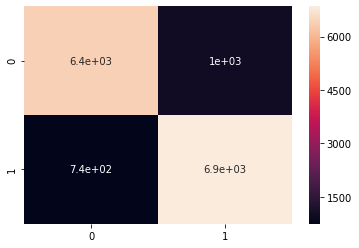

In [75]:
quality(Y_lsgd_pred, Y_test, 'SGDClassifier')

In [61]:
lrcv = LogisticRegressionCV(Cs=10, n_jobs=-1)
lrcv.fit(X_train_tfidf, Y_train)

/Users/edzhurae/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [63]:
Y_lrcv_pred = lrcv.predict(X_test_tfidf)

Metrics for LogisticRegressionCV
Accuracy:  0.907
Precision: 0.914
Recall:    0.904
F1-score:  0.909


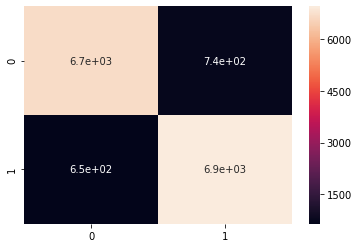

In [76]:
quality(Y_lrcv_pred, Y_test, 'LogisticRegressionCV')

In [155]:
def visualize_coefficients(coef, feature_names, title, plot_num, n_top_features=50):
    interesting_coefficients = np.argsort(coef)[::(-1)**plot_num][-n_top_features:]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

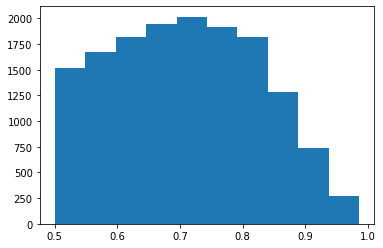

In [90]:
plt.hist(np.max(logit_sgd.predict_proba(X_test_tfidf), axis=1));

In [87]:
Y_train

array([0, 1, 0, ..., 0, 1, 1])

In [143]:
np.argsort(coef)[0][::(-1)**2]

array([ 33994, 467515,  32159, ...,  41755, 132385, 179690])

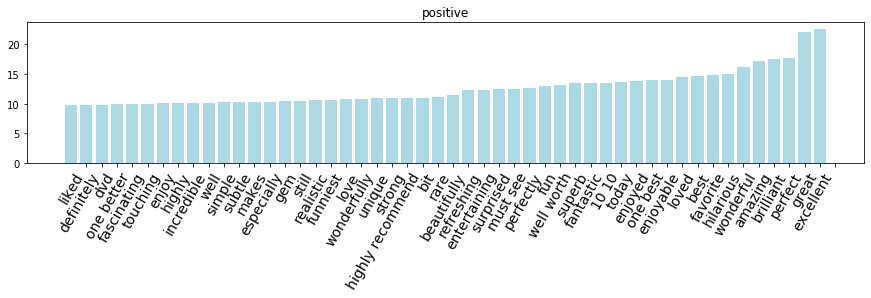

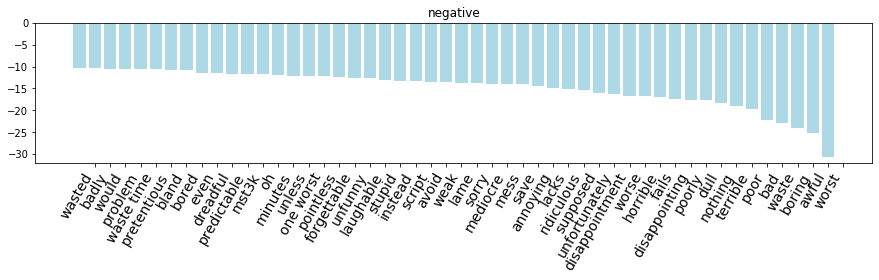

In [156]:
titles = ["positive", 'negative']
for i in range(2):
    visualize_coefficients(lrcv.coef_[0], tf_vectorizer.get_feature_names(),
                      title=titles[i], plot_num=i)